In [1]:
library(tidyverse)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



# Generate Simulated Data Set

In [3]:
library(tidyverse)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::combine()    masks randomForest::combine()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ ggplot2::margin()   masks randomForest::margin()
✖ dplyr::recode()     masks car::recode()
✖ purrr::some()       masks car::some()
✖ purrr::when()       masks foreach::when()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [4]:
## Functions used to generate fake data
set.seed(42)
f_fried <- function(x) 10 * sin(pi * x[,1] * x[,2]) + 20 * (x[,3] - 0.5)^2 + 
  10 * x[,4] + 5 * x[,5]

our_function <- function(x) sin(x[,1])*exp(x[,2])*10 + cos(2*x[,3]) - 20*x[,4]^2 + 3*x[,5]^3 - 15*x[,6]^(1/3) 

high_dimensional_func <- function(x) 10 * sin(pi * apply(x[,1:100], 1, prod)) + 20 * (apply(x[,101:150],1,sum) - 5)^2 + 
  10 * apply(x[,151:200],1,sum) + 5 * apply(x[,201:250],1,sum)

gen_data <- function(n_train, n_test, func, P, sigma, a, b) {
  X <- matrix(runif(n_train * P, a, b), nrow = n_train)
  mu <- func(X)
  X_test <- matrix(runif(n_test * P, a, b), nrow = n_test)
  mu_test <- func(X_test)
  Y <- mu + sigma * rnorm(n_train)
  Y_test <- mu_test + sigma * rnorm(n_test)
  
  return(list(X = X, Y = Y, mu = mu, X_test = X_test, Y_test = Y_test, mu_test = mu_test))
}



set.seed(42)
# only 5 predictors are important out of 50
sim_data_sparse <- gen_data(250, 100, f_fried, 50, 1, 0, 1)
sim_data <- sim_data_sparse

In [5]:
sim_data$X %>% head
sim_data$Y %>% head

0.9148060,0.33423133,0.1365052,0.24492099,0.84829322,0.73592037,0.05391100,0.1651787,0.9899656,0.24640458,⋯,0.5283896,0.53637297,0.003498503,0.03108833,0.7895760,0.90801477,0.5743560,0.04658951,0.5686084,0.70674255
0.9370754,0.18843433,0.1771364,0.08763591,0.06274633,0.75178575,0.95509577,0.7277811,0.4384936,0.02302811,⋯,0.6463879,0.02224803,0.470631273,0.37119592,0.6076812,0.22839369,0.3472568,0.81377534,0.2178806,0.93513637
0.2861395,0.26971618,0.5195605,0.39110850,0.81984509,0.33261448,0.02560094,0.2061579,0.6999032,0.28421418,⋯,0.8340490,0.97147909,0.447381378,0.28906588,0.9859969,0.03609499,0.5428427,0.06971775,0.1015155,0.32386434
0.8304476,0.53074408,0.8111208,0.18256143,0.53936029,0.05754862,0.92076314,0.5864655,0.8890770,0.81289268,⋯,0.3457626,0.60075658,0.418609717,0.14279648,0.6505679,0.75519239,0.2701957,0.45726551,0.6981023,0.42993684
0.6417455,0.02145023,0.1153620,0.13362478,0.49902010,0.67441545,0.36666474,0.9135460,0.8341595,0.71891839,⋯,0.6217329,0.41735487,0.865590246,0.64557472,0.3890771,0.14964131,0.7032647,0.93253494,0.1927258,0.26389910
0.5190959,0.79876031,0.8934218,0.25746291,0.02222732,0.04157017,0.69839255,0.2069666,0.7344215,0.52957674,⋯,0.6631953,0.35575149,0.089314849,0.83856468,0.7514495,0.15831393,0.2215922,0.56264178,0.8629308,0.06350469


[1] 19.972752 10.902433 11.908656 17.217049  5.817678 16.743031

# BART with 50 Predictors, 5 important

In [5]:
options(java.parameters = "-Xmx8g")
library(bartMachine)

Loading required package: rJava
Loading required package: bartMachineJARs
Loading required package: car
Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some

Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: missForest
Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: itertools
Loading required package: iterators
Welcome to bartMachine v1.2.3! You have 7.64GB memory available.

If you run out of memory, restart R, and use e.g.
'options(java.parameters = "-Xmx5g")' for 5GB of RAM b

In [6]:
#Include the parallel library. If the next line does not work, run install.packages(“parallel”) first
library(parallel)
library(doParallel)

# Use the detectCores() function to find the number of cores in system
n_cores <- detectCores()
print(n_cores)
cl <- makePSOCKcluster(n_cores)
#registerDoParallel(cl)
#stopCluster(cl)

[1] 16


In [7]:
set_bart_machine_num_cores(n_cores)

bartMachine now using 16 cores.


In [8]:
t.start <- Sys.time()
sim.bm <- bartMachine(X = sim_data$X %>% data.frame, y = sim_data$Y,
            verbose = TRUE, 
            serialize =  TRUE)
t.final <- Sys.time() - t.start
print(t.final)

bartMachine initializing with 50 trees...
bartMachine vars checked...
bartMachine java init...
bartMachine factors created...
bartMachine before preprocess...
bartMachine after preprocess... 51 total features...
bartMachine sigsq estimated...
bartMachine training data finalized...
Now building bartMachine for regression ...
evaluating in sample data...done
serializing in order to be saved for future R sessions...done
Time difference of 4.499073 secs


In [9]:
k_fold_cv(X = sim_data$X %>% data.frame, y = sim_data$Y,)

.....


$y_hat
  [1] 15.409691  9.073996 10.916044 16.089129  9.711665 15.442952 12.629337
  [8] 11.936272 22.873242 23.511404 20.927528 12.296638  9.977664  9.303849
 [15] 15.637721 14.245511 17.875563  6.481046 17.888305 15.920765 15.235453
 [22]  9.274405 14.420342 10.130119 12.292605  9.359868 16.618365 19.566689
 [29] 18.635177 20.980851 20.514726 10.809644  9.520463 10.418405 10.587365
 [36] 11.298309 12.904284  8.879588 15.020881  5.314906 19.997806 14.777634
 [43]  9.510134 12.652044 16.122010  9.815447 17.856212 16.670177 16.401992
 [50]  6.208811 20.839834 17.048928  5.906485 18.054578 13.191505 17.293247
 [57] 18.771206  7.287518  9.701940 14.439571  6.402919 22.989874 16.372272
 [64] 11.420758 14.981544 15.355566 17.320755 11.598383 11.752647 16.555773
 [71]  8.700211 10.405849  9.920751 12.960650  7.995051 22.569672 11.295444
 [78] 10.937595 11.238431  4.514297 14.047406 10.715752  5.201442 15.599670
 [85] 20.821232 14.535693 16.460706 15.087310 15.466759  4.916449 18.673467
 [92]  8.591130 10.261294 19.089656 11.607480  6.946890 12.717670 10.028139
 [99] 24.390667 13.708243 13.492737 18.186229  7.856190  9.981001 18.723030
[106] 11.623032 20.121830 21.441011 16.952282 16.557244 20.413519 18.140884
[113] 14.847317 13.794677 13.494736 19.363597  9.965233 15.622132 12.777615
[120] 15.343318 12.713191 20.131137 13.160774 14.891778 18.936039 19.980353
[127] 10.410770 12.754195  9.425231 18.715766 17.855694 19.207595 17.523390
[134] 16.156164 19.406324 14.376125  7.720347  5.693616 16.299691 15.586843
[141]  8.938840 16.399684 17.731479 14.714652 12.771931 16.758624  8.328438
[148] 10.015232 18.734345  9.345466  8.354359 12.539345 20.250155 11.111379
[155] 16.384925 17.748147 12.542086 10.223336  8.294794  9.256699 11.503009
[162] 17.273124 15.516849 18.213095 11.379149  9.147945 15.137170 13.185379
[169] 11.747486  3.679861 12.398075 19.988968 22.420753 13.277679 16.241744
[176] 11.391327 13.884023 15.876049 15.660009 18.097759 16.197175 21.684832
[183] 16.454636 13.179344 21.594612  8.871301 12.827288 13.064596  5.660430
[190] 17.106668 13.421952 20.568046  7.856734 11.071903 14.092204 11.643530
[197]  4.587896 15.808835 23.796661  4.670108 16.383469 12.972864 17.801873
[204] 17.388419 10.972202 17.432315 17.004313 21.189152 13.179907 16.143812
[211] 18.237914 17.949729  8.637311  9.017802  8.589916 22.262478  7.718705
[218]  6.269299 16.705642 16.454484 12.519386  6.477734 19.641719 16.790074
[225] 10.721126 16.629037 13.800877  9.800407 10.962155 10.330135 12.615342
[232]  9.679230 15.096423 13.593014 20.975864 14.866115 17.240191 10.153024
[239]  8.870484 14.031429 18.342851  9.270256 15.461064 18.801634 11.552201
[246]  9.651311 15.815105  8.075268 13.362491  7.056943

$L1_err
[1] 372.1445

$L2_err
[1] 863.8351

$rmse
[1] 1.858855

$PseudoRsq
[1] 0.863884

$folds
  [1] 4 3 5 1 2 1 4 4 4 5 3 3 1 3 1 2 4 1 1 3 5 5 4 2 3 4 3 2 4 3 4 2 3 5 4 2 5
 [38] 3 2 5 1 2 1 4 4 3 3 3 2 5 3 4 1 5 2 4 1 3 4 2 2 1 5 2 3 1 3 4 5 4 5 2 5 4
 [75] 3 1 5 4 4 3 1 1 3 5 3 1 4 2 2 3 5 1 2 5 3 2 5 2 3 3 3 4 4 5 1 5 4 4 1 4 5
[112] 5 5 4 4 1 4 3 5 4 1 5 2 4 1 5 3 3 2 4 3 5 1 2 5 5 4 3 2 4 1 2 2 2 4 2 3 5
[149] 5 2 1 3 1 5 2 1 5 2 1 5 5 4 1 4 5 5 5 1 1 3 1 2 1 1 1 5 4 1 1 4 2 3 5 3 5
[186] 1 2 5 5 4 2 3 3 5 3 4 1 2 3 4 3 1 2 2 1 3 4 4 4 1 2 2 1 2 5 5 4 4 2 1 4 3
[223] 3 3 2 2 1 2 2 3 5 2 4 5 5 3 2 1 3 3 2 2 1 1 1 4 3 5 2 1

In [10]:
sim.bm %>% summary

bartMachine v1.2.3 for regression

training data n = 250 and p = 50 
built in 3.6 secs on 16 cores, 50 trees, 250 burn-in and 1000 post. samples

sigsq est for y beforehand: 4.676 
avg sigsq estimate after burn-in: 1.64535 

in-sample statistics:
 L1 = 152.87 
 L2 = 146.96 
 rmse = 0.77 
 Pseudo-Rsq = 0.9768
p-val for shapiro-wilk test of normality of residuals: 0.35226 
p-val for zero-mean noise: 0.42357 



In [11]:
rmse <- function(actual, predicted){
    sqrt(mean((actual-predicted)^2))
}

In [12]:
rmse(sim_data$Y, predict(sim.bm, sim_data$X %>% data.frame)) #insample
rmse(sim_data$Y_test, predict(sim.bm, sim_data$X_test %>% data.frame)) #out of sample

[1] 0.7667002

[1] 1.909541

In [13]:
sim.bm %>% check_bart_error_assumptions

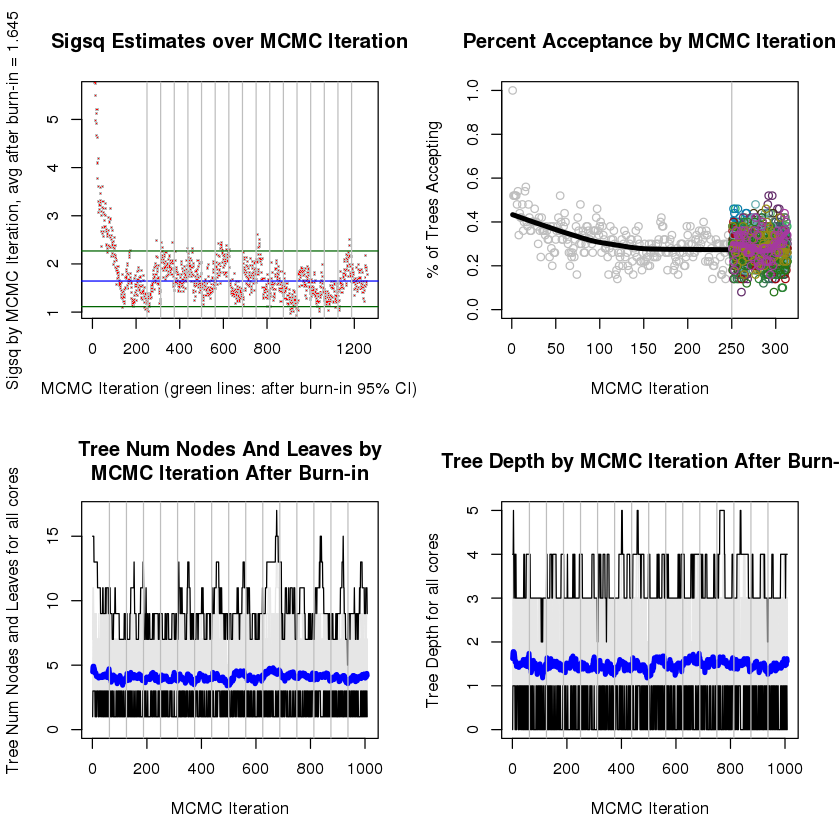

In [14]:
sim.bm %>% plot_convergence_diagnostics

....................


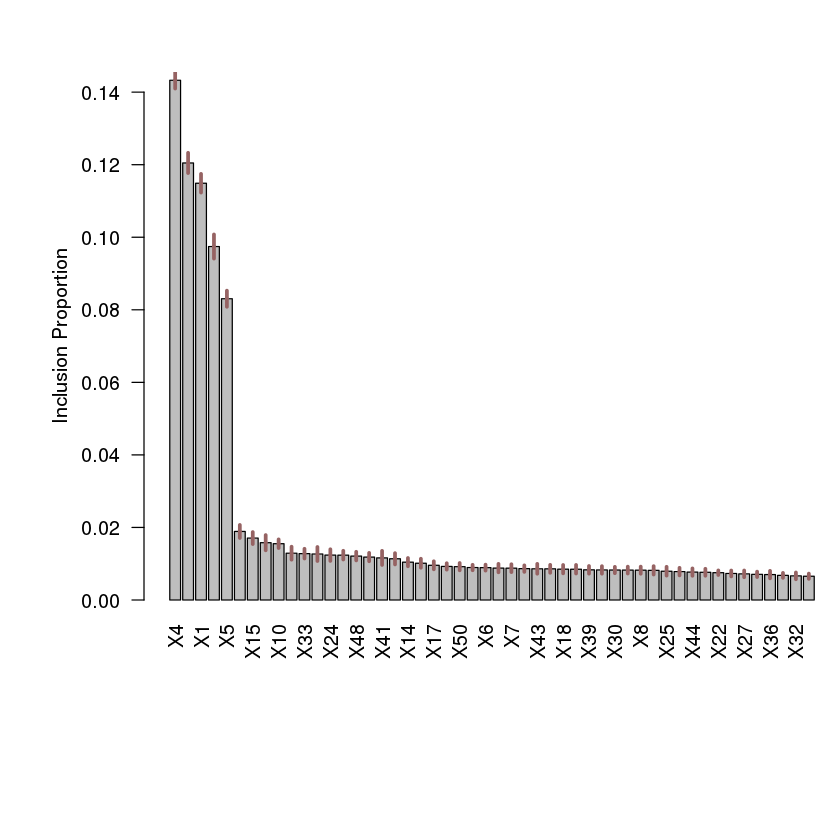

In [15]:
investigate_var_importance(sim.bm, num_replicates_for_avg = 20)

In [16]:
saveRDS(sim.bm,"model_files/simbm_sparse_model_v2_20191126.RDS")
sim.bm.read <- readRDS("model_files/simbm_sparse_model_v2_20191126.RDS")
sim.bm <- sim.bm.read

# DART with 50 Predictors, 5 important

In [1]:
options(java.parameters = "-Xmx8g")
library(dartMachine)

Loading required package: rJava
Loading required package: car
Loading required package: carData
Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: missForest
Loading required package: foreach
Loading required package: itertools
Loading required package: iterators
Welcome to bartMachine v1.2.0! You have 7.64GB memory available.



In [2]:
#Include the parallel library. If the next line does not work, run install.packages(“parallel”) first
library(parallel)
library(doParallel)

# Use the detectCores() function to find the number of cores in system
n_cores <- detectCores()
print(n_cores)
cl <- makePSOCKcluster(n_cores)
#registerDoParallel(cl)
#stopCluster(cl)

[1] 16


In [14]:
set_bart_machine_num_cores(n_cores)

bartMachine now using 16 cores.


In [6]:
t.start <- Sys.time()
sim.dartmachine <- bartMachine(X = sim_data$X %>% data.frame, y = sim_data$Y,
            verbose = TRUE, 
            serialize =  TRUE)
t.final <- Sys.time() - t.start
print(t.final)

bartMachine initializing with 50 trees...
Now building bartMachine for regression ...Covariate importance prior ON. 
evaluating in sample data...done
serializing in order to be saved for future R sessions...done
Time difference of 11.83983 secs


In [7]:
sim.dartmachine %>% summary

bartMachine v1.2.0 for regression

training data n = 250 and p = 50 
built in 7 secs on 1 core, 50 trees, 4000 burn-in and 4000 post. samples

sigsq est for y beforehand: 4.676 
avg sigsq estimate after burn-in: 0.66981 

in-sample statistics:
 L1 = 109.06 
 L2 = 87.96 
 rmse = 0.59 
 Pseudo-Rsq = 0.9861
p-val for shapiro-wilk test of normality of residuals: 0 
p-val for zero-mean noise: 0.65071 



In [8]:
rmse <- function(actual, predicted){
    sqrt(mean((actual-predicted)^2))
}

In [9]:
rmse(sim_data$Y, predict(sim.dartmachine, sim_data$X %>% data.frame)) #insample
rmse(sim_data$Y_test, predict(sim.dartmachine, sim_data$X_test %>% data.frame)) #out of sample

[1] 0.5931705

[1] 1.836039

In [10]:
sim.dartmachine %>% check_bart_error_assumptions

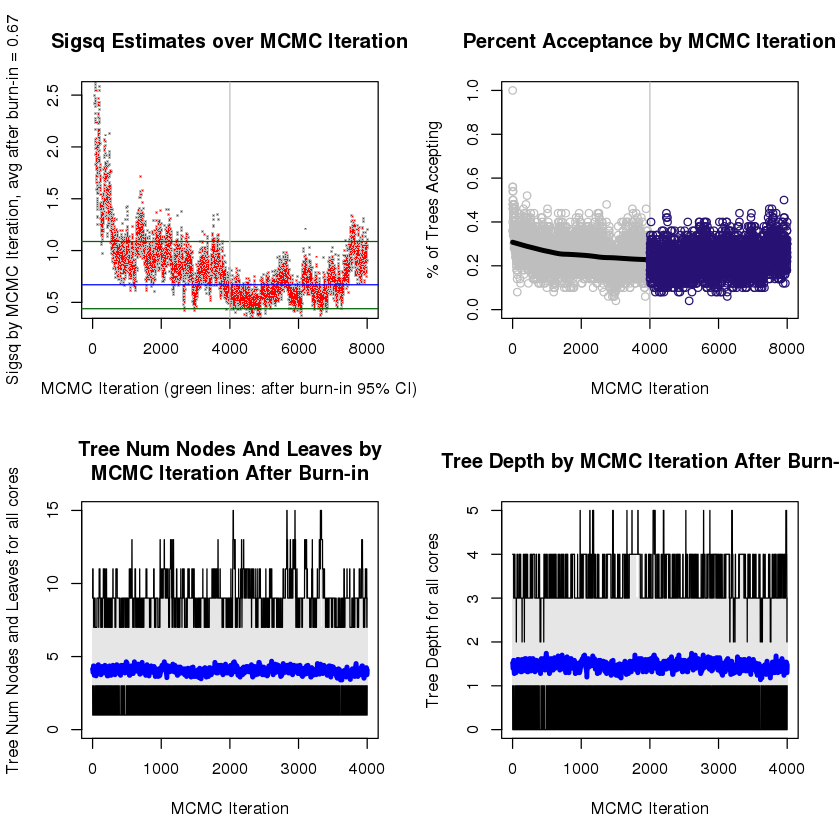

In [11]:
sim.dartmachine %>% plot_convergence_diagnostics

....................


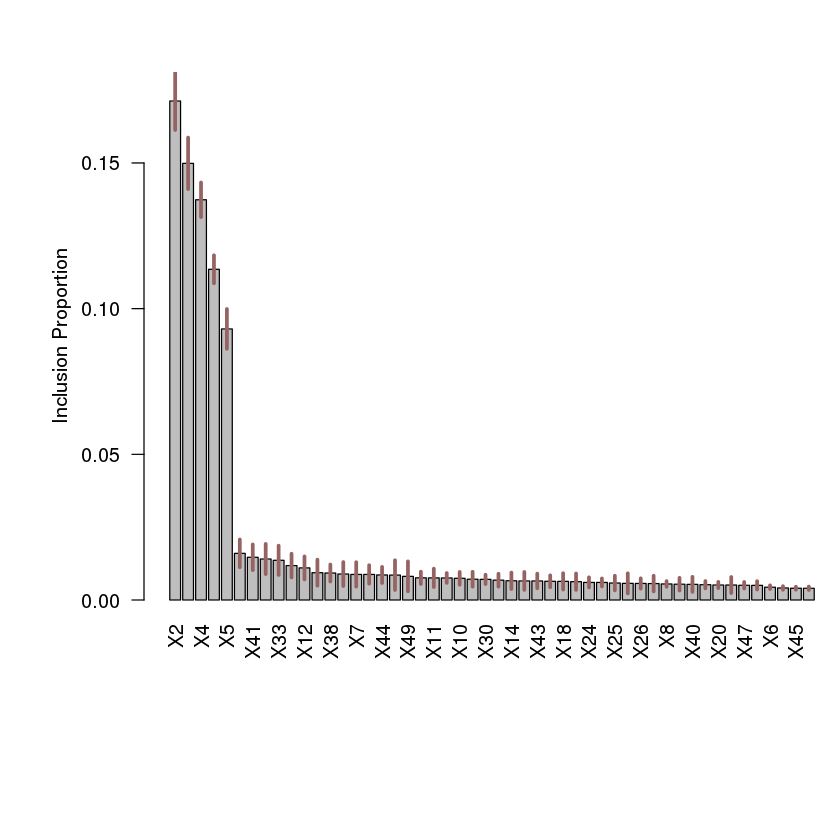

In [12]:
investigate_var_importance(sim.dartmachine, num_replicates_for_avg = 20)

In [13]:
saveRDS(sim.dartmachine,"model_files/simdartMachine_sparse_model_v2_20191126.RDS")
sim.dartmachine.read <- readRDS("model_files/simdartMachine_sparse_model_v2_20191126.RDS")
sim.dartmachine <- sim.dartmachine.read

# SoftBART with 50 Predictors, 5 important

In [17]:
library(SoftBart)

Loading required package: scales

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Loading required package: glmnet
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loaded glmnet 3.0-1

Loading required package: Rcpp


Finishing warmup 100 Number of trees = 50
Finishing warmup 200 Number of trees = 50
Finishing warmup 300 Number of trees = 50
Finishing warmup 400 Number of trees = 50
Finishing warmup 500 Number of trees = 50
Finishing warmup 600 Number of trees = 50
Finishing warmup 700 Number of trees = 50
Finishing warmup 800 Number of trees = 50
Finishing warmup 900 Number of trees = 50
Finishing warmup 1000 Number of trees = 50
Finishing warmup 1100 Number of trees = 50
Finishing warmup 1200 Number of trees = 50
Finishing warmup 1300 Number of trees = 50
Finishing warmup 1400 Number of trees = 50
Finishing warmup 1500 Number of trees = 50
Finishing warmup 1600 Number of trees = 50
Finishing warmup 1700 Number of trees = 50
Finishing warmup 1800 Number of trees = 50
Finishing warmup 1900 Number of trees = 50
Finishing warmup 2000 Number of trees = 50
Finishing warmup 2100 Number of trees = 50
Finishing warmup 2200 Number of trees = 50
Finishing warmup 2300 Number of trees = 50
Finishing warmup 240

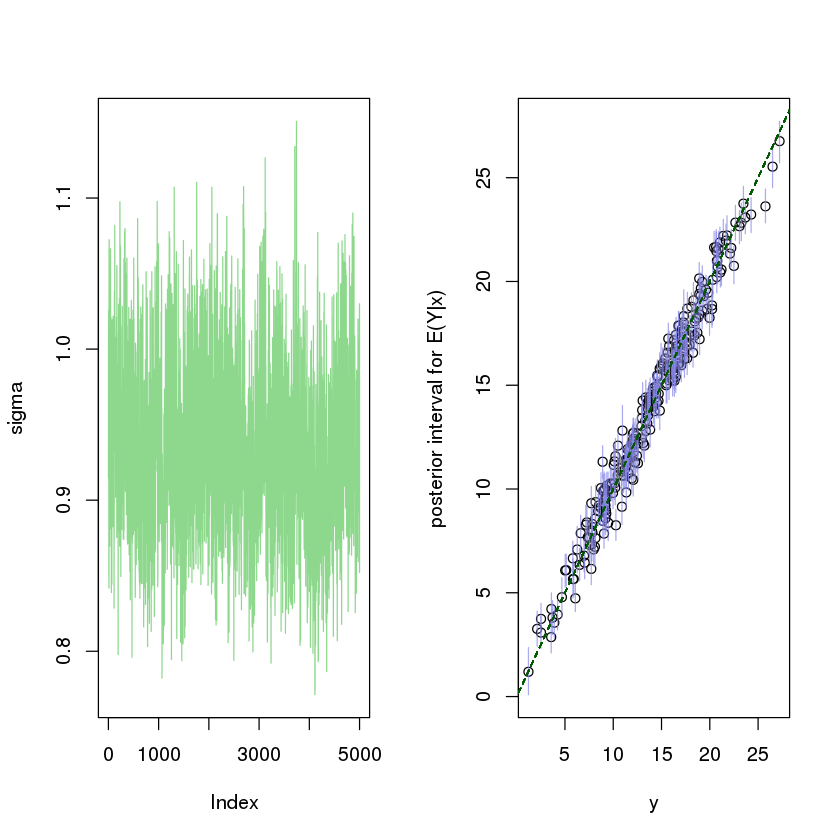

In [18]:
## Fit the models
softbart_fit_1 <- softbart(X = sim_data$X, Y = sim_data$Y, X_test = sim_data$X_test, 
                hypers = Hypers(sim_data$X, sim_data$Y, num_tree = 50, temperature = 1),
                opts = Opts(num_burn = 5000, num_save = 5000, update_tau = TRUE))

plot(softbart_fit_1)

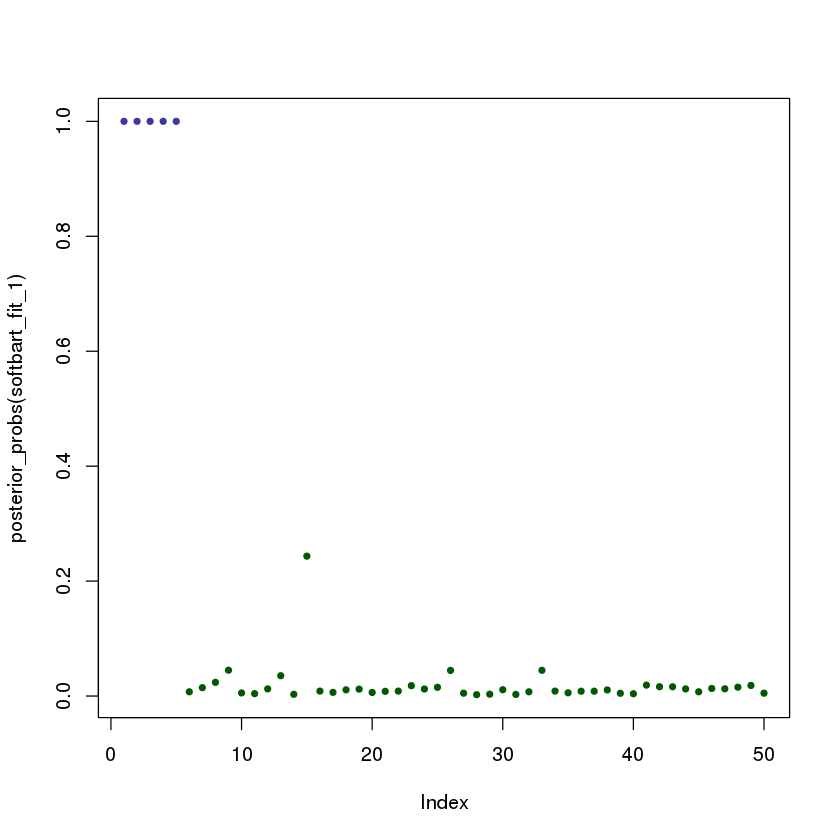

In [19]:
## Look at posterior model inclusion probabilities for each predictor. 

posterior_probs <- function(fit) colMeans(fit$var_counts > 0)
plot(posterior_probs(softbart_fit_1), 
     col = ifelse(posterior_probs(softbart_fit_1) > 0.5, muted("blue"), muted("green")), 
     pch = 20)

rmse <- function(x,y) sqrt(mean((x-y)^2))

In [24]:
rmse(softbart_fit_1$y_hat_train_mean, sim_data$Y)
rmse(softbart_fit_1$y_hat_test_mean, sim_data$Y_test)

[1] 0.7863366

[1] 1.212889

In [ ]:
softbart_fit_1.read

In [21]:
saveRDS(softbart_fit_1,file = "model_files/softbart_sparse_model_v2_20191126.RDS")

In [22]:
softbart_fit_1.read = readRDS("model_files/softbart_sparse_model_v2_20191126.RDS")
softbart_fit_1 <- softbart_fit_1.read